# Study of BioWeb data (tool annotation)

In [1]:
import scipy.spatial
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import fcluster
import matplotlib.pyplot as plt
import json
import seaborn as sns
import re
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
sns.set(style = 'darkgrid', palette = 'Set2')
taille = (9, 5)

In [3]:
with open('../biocontainers.json', 'r') as f:
  biocontainers = json.load(f)

____

## Auxiliary Functions

In [4]:
#Function that returns all the tags and tags lastword of a list of tools
def get_tags_tags_lastword(tools):
    tags, tags_lastword = [], []
    for tool in tools:
        tags+=biocontainers[tool]['tags']
        for t in biocontainers[tool]['tags']:
            tags_lastword+= [t.split(':')[-1]]


    tags = list(set(tags))
    tags_lastword = list(set(tags_lastword))

    return tags, tags_lastword

In [5]:
#Function that buils the binary matrice 
def make_binary_dataframe(tools, feature, feature_label):
    #Colums -> feature
    #Rows -> tools
    #For the matrice the first index is the row (tool) AND second index is the colum
    binary_matrice = np.zeros((len(tools), len(feature)))

    tool_indice = 0
    for t in tools:
        feature_indice = 0

        if(feature_label == 'tags_lastword'):
            check_tags = biocontainers[t]['tags'].copy()
            for i in range(len(check_tags)):
                check_tags[i] = check_tags[i].split(":")[-1]
        
        for f in feature:

            if(feature_label == 'tags_lastword'):
                if(f in check_tags):
                    binary_matrice[tool_indice][feature_indice] = 1

            if(feature_label == 'tags'):
                if(f in biocontainers[t][feature_label]):
                    binary_matrice[tool_indice][feature_indice] = 1
            feature_indice+=1
        
        tool_indice+=1
    
    #df = pd.DataFrame(binary_matrice+0.01)
    df = pd.DataFrame(binary_matrice)
    df.columns = feature
    df.index = tools

    return df

In [6]:
#List of different metrics here : https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html
#List of different methods here : https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
#dendrogram options here : https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html

def make_tree(binary_df, metric='jaccard', method="ward", nb_cluster = 3, return_clusters = True, **kwargs):
    jaccard = scipy.spatial.distance.cdist(binary_df, binary_df,  
                                       metric=metric)
    user_distance = 1-pd.DataFrame(jaccard, columns=binary_df.index.values,  
                                index=binary_df.index.values)
    Z = linkage(user_distance, method=method)
    fig = plt.figure()
    dn = dendrogram(Z, **kwargs)

    if(return_clusters):
        df = pd.DataFrame(list(zip(fcluster(Z, nb_cluster, criterion='maxclust'), binary_df.index)),
                columns =['cluster_labels', 'tool'])

        dico = {}
        for i in range(1, nb_cluster+1):
            dico[i] = list(df[df["cluster_labels"]==i]['tool'])

        return dico
    

___

## Let's explore the data

In [7]:
tags, tags_lastword = get_tags_tags_lastword(biocontainers)

In [8]:
len(tags)

240

### Let's first a simple clustering of the tools on topics

In [9]:
binary = make_binary_dataframe(biocontainers, tags_lastword, 'tags_lastword')

<AxesSubplot: ylabel='Count'>

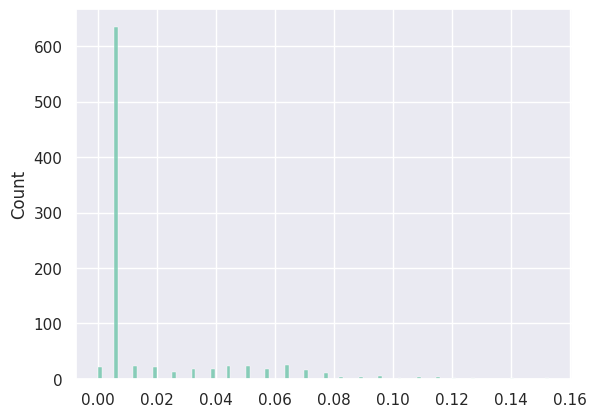

In [10]:
sns.histplot(binary.mean(axis=1))

This histogram represents the distribution of the tools having the percentage of the tags_lastword associated. That's not very clear, but for example, it means that over 600 tools only have assocated 0.01% of the tags_lastword, around 20 tools have 4% of the tags_lastword associated and so on...

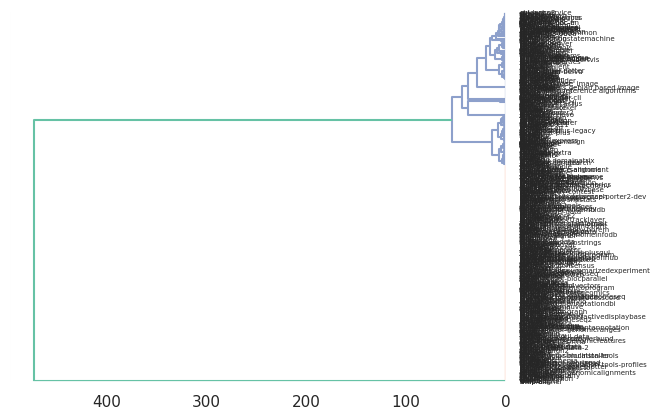

In [11]:
make_tree(binary, metric='jaccard', method="ward", return_clusters = False, labels = list(binary.index), orientation = "left")

This clustering isn't very clear -> we can't really extract any interestring information from it (it is the same for tags!)

___

## We need to explore the data in a more intelligent way

Instead of doing the clustering on all the tools -> let's select a subset of tools to do the clustering on. We're only gonna keep the tools with 15 or more tags annotations

In [12]:
binary = make_binary_dataframe(biocontainers, tags, 'tags')
binary['test'] = binary.sum(axis=1) <15
binary = binary.drop(binary[binary['test'] == True].index)
binary = binary.drop(columns="test")

{1: ['gdpc', 'adun.app', 'ctn', 'imagej', 'medcon'],
 2: ['clustalx', 'ncbi-tools-x11', 'njplot', 'ltrsift', 'artemis'],
 3: ['plasmidomics', 'gnumed-client', 'treeviewx'],
 4: ['ncbi-tools-bin',
  'samtools',
  'melting',
  'altree',
  'boxshade',
  'seaview',
  'emboss',
  'perlprimer',
  'gff2aplot',
  'cwltool']}

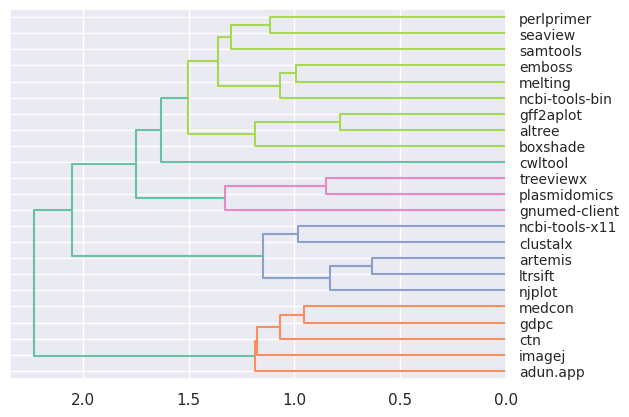

In [13]:
make_tree(binary, metric='jaccard', method="ward", nb_cluster=4, labels = list(binary.index), orientation = "left")


## Study on subset of tools

In the examples above it is difficult to judge the quality of the clustering since there are just so many tools, and it takes time to read/learn the functionality of each tool. To solve this i'm gonna work from a subset of tools which i know what they do (and the correct clustering), so i can judge the result at a glance.

Here are the tools (which i choose without any prior knowledge of the quality pf their annotation in BioWeb (expect for the 2 blasts -> but you can remove them and we get the sames results)), which i've decided to work on and their "groups":


* Mapping :
  * Transcript :
    * **STAR**
    * **tophat**
  * Genome :
    * **bwa**
    * **bowtie**
* Counting :
  * **featureCounts**
* Trimming : 
  * **Trimmomatic**
  * **cutadapt**
* MultiQc :
  * **mutliqc**
* General :
  * **samtools**
* Blast :
  * **blast**
  * **blast+**

So a total of 11 tools



In [14]:
studied_tools = ['tophat', 'bwa', 'bowtie', 'trimmomatic', 'cutadapt', "samtools", "blast2", "ncbi-blast-plus"]

**featureCounts**, **star**, **multiqc** are not in BioContainers, so i'm gonna remove these tool from the study

In [15]:
tags, tags_lastword = get_tags_tags_lastword(biocontainers)

In [16]:
print(f"From the subset of tools, **{len(tags)}** tags and **{len(tags_lastword)}** tags_lastword have been extracted")

From the subset of tools, **240** tags and **157** tags_lastword have been extracted


### Study Feature = tags

In [17]:
binary = make_binary_dataframe(studied_tools, tags, 'tags')

<AxesSubplot: ylabel='Count'>

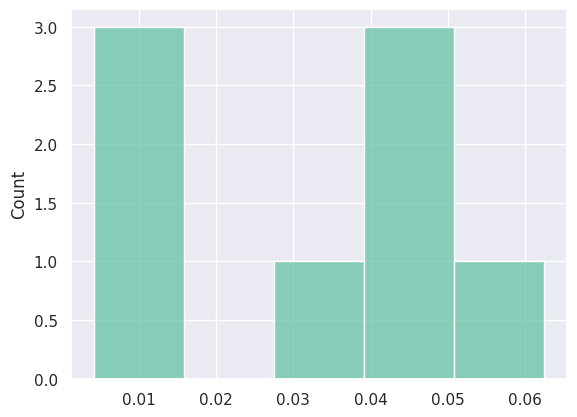

In [18]:
sns.histplot(binary.mean(axis=1), bins=5)

This histogram represents the distribution of the tools having the percentage of the tags associated. That's not very clear, but for example, it means that 5 tools only have assocated 7% of the tags

{1: ['trimmomatic', 'cutadapt'],
 2: ['bwa', 'bowtie', 'samtools', 'blast2', 'ncbi-blast-plus'],
 3: ['tophat']}

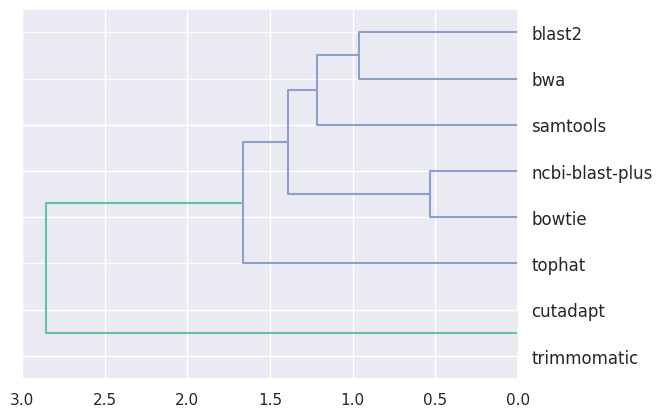

In [19]:
make_tree(binary, metric='jaccard', method="ward", nb_cluster = 3, labels = list(binary.index), orientation = "left")

### Study Feature = tags_lastword

In [20]:
binary = make_binary_dataframe(studied_tools, tags_lastword, 'tags_lastword')

<AxesSubplot: ylabel='Count'>

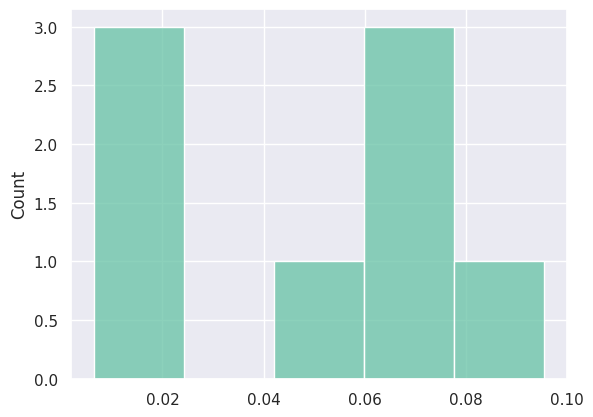

In [21]:
sns.histplot(binary.mean(axis=1), bins=5)

This histogram represents the distribution of the tools having the percentage of the tags_lastword associated. That's not very clear, but for example, it means that 3 tools only have assocated 7% of the tags_lastword

{1: ['trimmomatic', 'cutadapt'],
 2: ['bowtie', 'ncbi-blast-plus'],
 3: ['bwa'],
 4: ['blast2'],
 5: ['samtools'],
 6: ['tophat']}

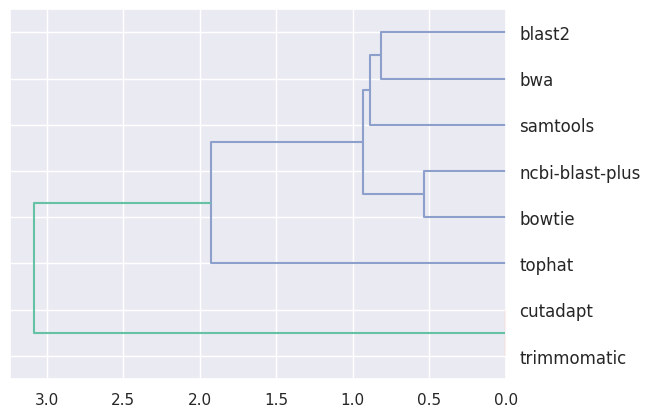

In [22]:
make_tree(binary, metric='jaccard', method="ward", nb_cluster = 6, labels = list(binary.index), orientation = "left")

## Conclusion

The clustering of the tools with biocontainers is no where near as good as with bioweb -> they could potentially compliment each other though